In [1]:
import sys, os
from pathlib import Path
import json
home_path = "/Users/nd21aad/Phd/Projects/enose-analysis-crick"  # Define project root directory
os.chdir(home_path)         # Change working directory to project root directory
sys.path.append(home_path)  # Add project root directory to python path
home_path = Path(home_path)

import numpy as np
import matplotlib as mpl
import pandas as pd
pd.set_option("display.max_columns", None)
new_rc_params = {"text.usetex": False, "svg.fonttype": "none"}
mpl.rcParams.update(new_rc_params)

import src.pulse_classification.analysis as analysis
import src.utils.constants as constants
import src.utils.misc as misc
import src.pulse_classification.helpers as utils
import src.visualizations.pulse_classification as visualizations

np.random.seed(42)

In [2]:
# Define data dirs
parent_dir = Path('/Volumes/SSDExtreme/Work/Data/Crick')    # Change this to the directory where you store the data
data_dir_enose = parent_dir.joinpath('Dataset-FastMachineOlfaction/Enose')
data_dir_pid = parent_dir.joinpath('Dataset-FastMachineOlfaction/PID/Full')
assert data_dir_enose.exists(), f'{data_dir_enose} does not exist'
assert data_dir_pid.exists(), f'{data_dir_pid} does not exist'

# Define result directory
result_dir_parent = home_path.joinpath("results/pulse_classification")
result_dir = result_dir_parent.joinpath('static')
result_dir.mkdir(exist_ok=True, parents=True)

In [3]:
# Load data index
index_file = data_dir_enose.joinpath("index.csv")
index_df = pd.read_csv(index_file)
index_df = index_df.replace('b1', 'blank')
index_df = index_df.replace('b2', 'blank')
index_df = index_df[index_df['condition']=='LconstRcycle25ms']

# Select data instances
# 1s pulses, highest concentration
index_df_pulses_1s_c5 = index_df.query(f"kind == 'pulse' & shape == '1.0s' & concentration == 100 & n_saturated == 0")
# 1s pulses, all other concentrations
index_df_pulses_1s_c1234 = index_df.query(f"kind == 'pulse' & shape == '1.0s' & concentration != 100 & n_saturated == 0")

# Split data
f_test = 0.4     # ensures same sample size as for low concentration pulses
index_df_pulses_1s_c5_train, index_df_pulses_1s_c5_test = utils.split_traintest_time(index_df_pulses_1s_c5, f_test=f_test, stratified=False, time_split=True)
index_df_pulses_1s_c5_test = index_df_pulses_1s_c5_test.query(constants.string_noblank)
index_df_pulses_1s_c1234_train, index_df_pulses_1s_c1234_test = utils.split_traintest_time(index_df_pulses_1s_c1234, f_test=f_test, stratified=False, time_split=True)
gases_train = index_df_pulses_1s_c5_train['gas1']
gases_test = index_df_pulses_1s_c5_test['gas1']

# Set params
params = {
    # "data_dir": data_dir,
    "colors": constants.colors,
    "gases": ["IA", "Eu", "EB", "2H", "blank"],
    "period": 50,
    "ncycles": constants.n_all_cycles,
    "cycles_gas": constants.cycles_gas,
    "cycles_blank": constants.cycles_blank,
    "midpoint": constants.midpoint,
    "endpoints": constants.endpoints,
    "delay": constants.delay,
    "on_buffer": 500, # Set generous buffer to skip ambivalent gas phase
    "off_buffer": 500, # Set generous buffer to skip ambivalent gas phase
    "ms_start": -1000,
    "ms_on": 0,
    "ms_off": 1000,
    "ms_end": 3000,
    "classifier": 'kNN',
}
# Define feature - sensors pairs 
features_all = ['constant_raw', 'constant_subtracted', 'cycle_raw', 'cycle_signature']
sensors = [1,2,3,4]


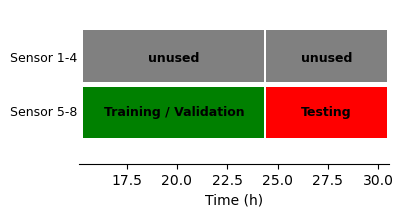

In [4]:
# Plot train/test split
visualizations.plot_traintest_split_static(index_df_pulses_1s_c5_train, index_df_pulses_1s_c5_test, result_dir, show=True)

In [5]:
# Train classifier on pulses, test on concentration range

# Initialise analysis
analysis_enose = analysis.Analysis(data_dir_enose, params=params)
# Load data
trial_data = analysis_enose.get_trial_data(index_df_pulses_1s_c5_train, sensors=sensors)

In [6]:
# Train & validate on 1s pulses at C=100%

# Get kfold indices
kfold_indices_train, kfold_indices_val = utils.get_kfold_indices(selected=index_df_pulses_1s_c5_train)
# Train / validate
all_models = analysis.train_validate_static(analysis_enose, trial_data, kfold_indices_train, kfold_indices_val, sensors, features_all, params)

C=100%: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


In [7]:
# Validate on 1s pulses at C=20-80%
concentrations = [20, 40, 60, 80]
scores_val, confmats_val, labels_val = analysis.validate_static_concentrationvars(all_models, analysis_enose, concentrations, index_df_pulses_1s_c1234_train, sensors, features_all, params) # TODO: what's up with feature?

C=80%: 100%|██████████| 4/4 [00:14<00:00,  3.59s/it]


In [8]:
# Test on concentration pulses
print("Test on 20-100% 1s pulses from test split")
concentrations = [20, 40, 60, 80, 100]
scores_test, confmats, labels = analysis.test_static_concentrationvars(all_models, analysis_enose, concentrations, index_df_pulses_1s_c1234_test, index_df_pulses_1s_c5_test, sensors, features_all, params)

# Save results
json.dump(scores_test, open(result_dir.joinpath(f'scores_{params["classifier"]}_allfeatures.json'), 'w'), default=misc.custom_encoder) # TODO: what's up with feature?
json.dump(confmats, open(result_dir.joinpath(f'confmats_{params["classifier"]}_allfeatures.json'), 'w'), default=misc.custom_encoder)
json.dump(labels, open(result_dir.joinpath(f'labels_{params["classifier"]}_allfeatures.json'), 'w'), default=misc.custom_encoder)
print('Done. Results saved in ', result_dir)

Test on 20-100% 1s pulses from test split


C=100%: 100%|██████████| 4/4 [00:41<00:00, 10.43s/it]

Done. Results saved in  /Users/nd21aad/Phd/Projects/enose-analysis-crick/results/pulse_classification/static


In [9]:
# Plot scores and confusion matrices for different concentrations
feature = 'cycle_signature'
scores = json.load(open(result_dir.joinpath(f'scores_{params["classifier"]}_allfeatures.json'), 'r'), object_hook=misc.custom_decoder)
confmats = json.load(open(result_dir.joinpath(f'confmats_{params["classifier"]}_allfeatures.json'), 'r'), object_hook=misc.custom_decoder)
labels = json.load(open(result_dir.joinpath(f'labels_{params["classifier"]}_allfeatures.json'), 'r'), object_hook=misc.custom_decoder)

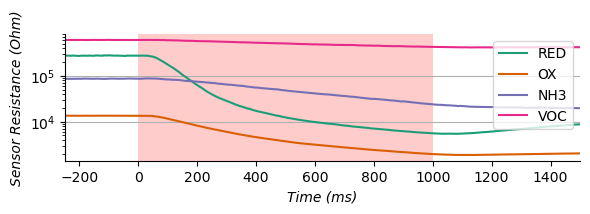

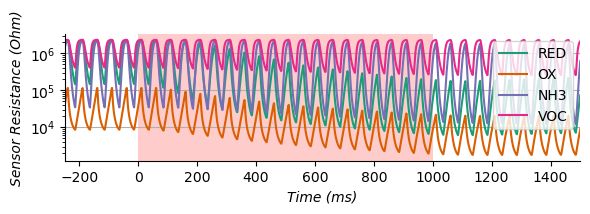

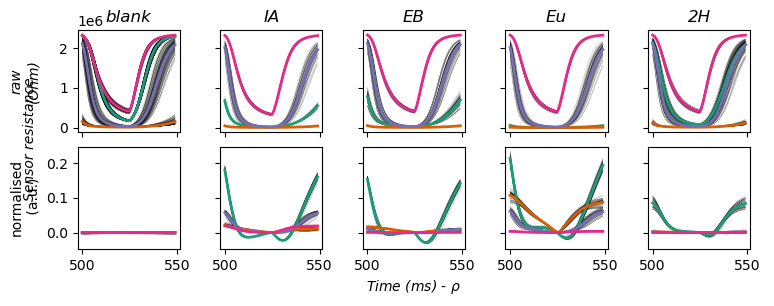

In [10]:
# Plot time series for constant heat and cycles 
sensors_all = [[5,6,7,8], [5,6,7,8]]
analysis_enose = analysis.Analysis(data_dir_enose, params=params)
visualizations.feature_plot_trial(analysis_enose, index_df_pulses_1s_c5, gas_selected='IA', result_dir=result_dir)
visualizations.feature_summary_plot(analysis_enose, index_df_pulses_1s_c5, sensors_all[-2:], features_all[-2:], phase=500, results_dir_features=result_dir, params=params)

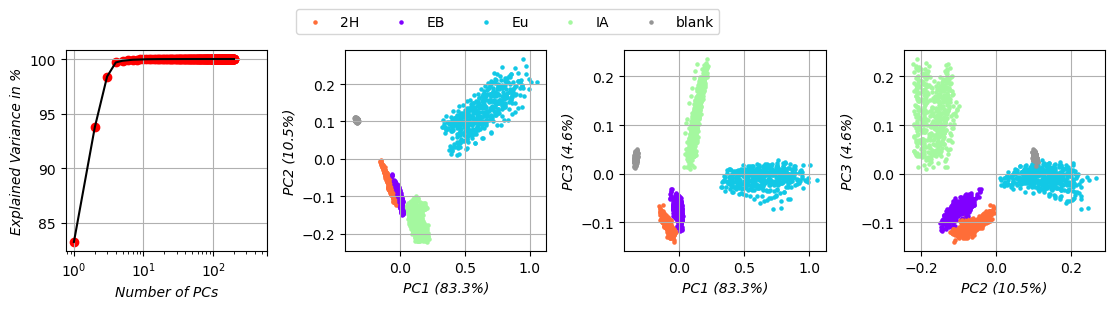

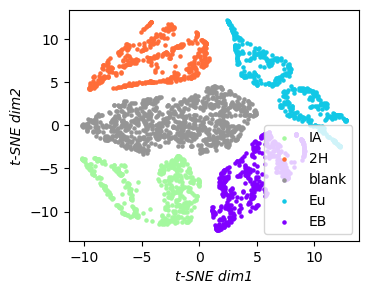

In [11]:
# Get data for PCA and T-SNE
trial_data = analysis_enose.get_trial_data(index_df_pulses_1s_c5, sensors=[5,6,7,8])
# Get cycled features
feature = "cycle_signature"
params["off_buffer"] = 10000
X_all, y_gas1_all, y_gas2_all, phases_all, phases_rejected_all = analysis_enose.get_X_y_ph(trial_data_all=trial_data, feature=feature, params=params)

# Pooling features together
X, y = np.array(X_all), np.array(y_gas1_all)
X, y = X.reshape(X.shape[0]*X.shape[1], -1), y.reshape(-1)

# PCA
visualizations.pca_plots_new(X, y, result_dir, standard_scaler=False, feature=feature)

# T-SNE
visualizations.tsne_plot(X, y, feature, result_dir, perplexity=20)

cycle_raw
C=100%: 0.8908396946564885 pm 0.019497637073734298
C=80%: 0.7067357512953367 pm 0.009609967352845278
C=60%: 0.42777777777777776 pm 0.01109180421362125
C=40%: 0.33687707641196013 pm 0.004382360783479384
C=20%: 0.42762063227953406 pm 0.02264362840093711
cycle_signature
C=100%: 0.9581424936386768 pm 0.002525373185913385
C=80%: 0.911658031088083 pm 0.004365880711490357
C=60%: 0.837037037037037 pm 0.007965115988002466
C=40%: 0.7112956810631229 pm 0.00829900066232344
C=20%: 0.5653910149750415 pm 0.003705666797224675


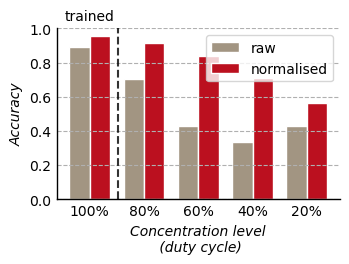

constant_raw
C=100%: 0.8908396946564885 pm 0.019497637073734298
C=80%: 0.7067357512953367 pm 0.009609967352845278
C=60%: 0.42777777777777776 pm 0.01109180421362125
C=40%: 0.33687707641196013 pm 0.004382360783479384
C=20%: 0.42762063227953406 pm 0.02264362840093711
constant_subtracted
C=100%: 0.7932569974554708 pm 0.02766115148807977
C=80%: 0.5735751295336788 pm 0.011451832178912096
C=60%: 0.5597222222222222 pm 0.009189552426518137
C=40%: 0.31860465116279074 pm 0.005499317394434163
C=20%: 0.4183028286189684 pm 0.001696845096037531
cycle_raw
C=100%: 0.8908396946564885 pm 0.019497637073734298
C=80%: 0.7067357512953367 pm 0.009609967352845278
C=60%: 0.42777777777777776 pm 0.01109180421362125
C=40%: 0.33687707641196013 pm 0.004382360783479384
C=20%: 0.42762063227953406 pm 0.02264362840093711
cycle_signature
C=100%: 0.9581424936386768 pm 0.002525373185913385
C=80%: 0.911658031088083 pm 0.004365880711490357
C=60%: 0.837037037037037 pm 0.007965115988002466
C=40%: 0.7112956810631229 pm 0.008299

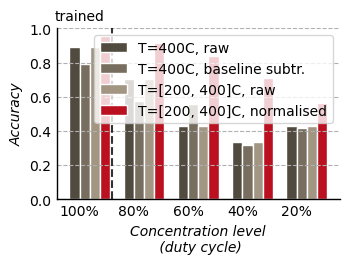

In [12]:
# Plot score barplots for the different features and different concentrations, combined
visualizations.score_plot_bars_multifeatures(scores_test, result_dir, features_all[-2:])
visualizations.score_plot_bars_multifeatures(scores_test, result_dir, features_all)